In [1]:
import sys
sys.path.append('../../30_data_tools/')

In [2]:
# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics import Accuracy, Recall, Precision
from torchinfo import summary
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
from tqdm.auto import tqdm

In [3]:
from pathlib import Path
from helper import load_dotenv
from pytorch_model_tools import get_datasets, train, validate

In [4]:
dotenv = load_dotenv()

In [ ]:
mlflow.set_tracking_uri(dotenv['MFLOW_DB_PATH'])
mlflow.set_experiment("moire_detection")

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [5]:
available_datasets = get_datasets()
#available_datasets = get_datasets( dataset_directory=(dotenv['TEMP_PROCESSING_DIR'] / '..' / 'idiotentest') )

real_val size 1675
test size 16425
train size 106255
val size 7853
class names ['no_moire']


In [6]:
import numpy as np
from PIL import Image

tensor(1)


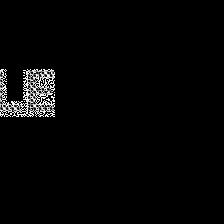

In [55]:
X,y = next(iter(available_datasets['val']['dataloader']))
print(y[0])

Image.fromarray(np.array(X[0,0] * 255).astype('uint8'))

# get model

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features 
# Add a fully-connected layer for classification
model.fc = nn.Sequential(
    nn.Linear(num_features, 2),
    nn.Sigmoid()
)
model = model.to(device)

# Train

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
epochs = 15
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task="multiclass", num_classes=2).to(device)
recall_fn = Recall(task="multiclass", average='macro', num_classes=2).to(device)
precision_fn = Precision(task="multiclass", average='macro', num_classes=2).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": 0.0001,
        "batch_size": 64,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": accuracy_fn.__class__.__name__,
        "optimizer": "SGD",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    for t in tqdm(range(epochs)):
        print(f"Epoch {t+1} -------------------------------")
        train(available_datasets['train']['dataloader'], model, device, loss_fn, optimizer, metrics=[('accuracy',accuracy_fn), ('recall',recall_fn), ('precision',precision_fn)] )
        #print("validate")
        #validate(available_datasets['val']['dataloader'], model, device, loss_fn, metrics=[('accuracy',accuracy_fn), ('recall',recall_fn), ('precision',precision_fn)] )

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

In [ ]:
mlflow.pytorch.log_model(model, "model")

In [ ]:
torch.save(model, dotenv['MODEL_DIR'] / '24-04-02_01_resnet50.pth' )

In [ ]:
validate(available_datasets['val']['dataloader'], model, device, loss_fn, metrics=[('accuracy',accuracy_fn), ('recall',recall_fn), ('precision',precision_fn)] )

In [ ]:
0 / 0